Input dropout + Sparse

In [44]:
import numpy as np
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

from codes.utils import *
from codes.process import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

random_seed=42
bed_root = '/home2/jpark/Projects/prs/data/bed'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [165]:
train_type = 'test'
fold_num = 1
in_fold_num = 1
y_value = 'y'
ex_num = 100

In [200]:
# Train data
bed_X_train = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'train', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}.raw",
    delim_whitespace=True)
bed_X_train = bed_X_train.iloc[:, [1] + list(range(6, len(bed_X_train.columns)))]
bed_y_train = pd.read_csv(get_bed_path('label', 'train', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
bed_data_train = bed_X_train.merge(bed_y_train, on='IID')

# Test data
bed_X_test = pd.read_csv(f"{get_bed_path('keep_bed_yi_ex', 'test', fold_num, in_fold_num=in_fold_num, y=y_value, ex=ex_num)}.raw",
    delim_whitespace=True)
bed_X_test = bed_X_test.iloc[:, [1] + list(range(6, len(bed_X_test.columns)))]
bed_y_test = pd.read_csv(get_bed_path('label', 'test', fold_num, in_fold_num=in_fold_num), delim_whitespace=True)[['IID', y_value]]
bed_data_test = bed_X_test.merge(bed_y_test, on='IID')

In [260]:
X_train = bed_data_train.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
y_train = bed_data_train[y_value].to_numpy().astype(np.int32)
X_test = bed_data_test.drop(['IID', y_value], axis=1).to_numpy().astype(np.float32)
y_test = bed_data_test[y_value].to_numpy().astype(np.int32)

n_inputs = X_train.shape[1]
n_hidden1 = X_train.shape[1]*2
n_outputs = n_inputs

In [261]:
#(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
#X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
#X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
#y_train = y_train.astype(np.int32)
#y_test = y_test.astype(np.int32)
#X_valid, X_train = X_train[:5000], X_train[5000:]
#y_valid, y_train = y_train[:5000], y_train[5000:]

def shuffle_X_batch(X, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch = X[batch_idx]
        yield X_batch

In [262]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

# For training
learning_rate = 0.01

# For sparsity
sparsity_target = 0.1
sparsity_weight = 0.2

# For input dropout
dropout_rate = 0.3

# init
training = tf.placeholder_with_default(False, shape=(), name='training')


##### Build Model #####
# input
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# layers
X_drop = tf.layers.dropout(X, dropout_rate, training=training)
hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.sigmoid)  # Input dropout
logits = tf.layers.dense(hidden1, n_outputs)

# output
outputs = tf.nn.sigmoid(logits)


##### Construct Loss #####
# sparsity loss
hidden1_mean = tf.reduce_mean(hidden1, axis=0)
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))

# cross  entropy 
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)  # Compare with X not X_drop

# Loss
reconstruction_loss = tf.reduce_mean(xentropy)
loss = reconstruction_loss + sparsity_weight * sparsity_loss

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [263]:
reset_graph
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [270]:
n_epochs = 100
batch_size = 1000

loss_test_min = 1000
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = next(shuffle_X_batch(X_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        r_loss_train, s_loss_train, loss_train = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        r_loss_test, s_loss_test, loss_test = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_test})
        print(f'\r{epoch} Train - Cross entropy:, {r_loss_train:.4f}, \tSparsity loss:, {s_loss_train:.4f}, \tLoss:, {loss_train:.4f}')
        print(f'\r{epoch} Test  - Cross entropy:, {r_loss_test:.4f}, \tSparsity loss:, {s_loss_test:.4f}, \tLoss:, {loss_test:.4f}')
        if loss_test_min > loss_test:
            loss_test_min = loss_test
            saver.save(sess, "./model/my_model_sparse.ckpt")

0 Train - Cross entropy:, 0.3461, 	Sparsity loss:, 29.1184, 	Loss:, 6.1698
0 Test  - Cross entropy:, 0.3520, 	Sparsity loss:, 29.6174, 	Loss:, 6.2755
1 Train - Cross entropy:, 0.4151, 	Sparsity loss:, 8.8636, 	Loss:, 2.1878
1 Test  - Cross entropy:, 0.4326, 	Sparsity loss:, 9.9727, 	Loss:, 2.4271
2 Train - Cross entropy:, 0.4600, 	Sparsity loss:, 2.9960, 	Loss:, 1.0592
2 Test  - Cross entropy:, 0.4646, 	Sparsity loss:, 3.6497, 	Loss:, 1.1946
3 Train - Cross entropy:, 0.4546, 	Sparsity loss:, 1.3065, 	Loss:, 0.7159
3 Test  - Cross entropy:, 0.4532, 	Sparsity loss:, 1.4871, 	Loss:, 0.7506
4 Train - Cross entropy:, 0.4375, 	Sparsity loss:, 0.4013, 	Loss:, 0.5178
4 Test  - Cross entropy:, 0.4328, 	Sparsity loss:, 0.6522, 	Loss:, 0.5632
5 Train - Cross entropy:, 0.4245, 	Sparsity loss:, 0.1526, 	Loss:, 0.4551
5 Test  - Cross entropy:, 0.4192, 	Sparsity loss:, 0.2980, 	Loss:, 0.4788
6 Train - Cross entropy:, 0.4229, 	Sparsity loss:, 0.0302, 	Loss:, 0.4289
6 Test  - Cross entropy:, 0.4116, 	S

55 Train - Cross entropy:, 0.1022, 	Sparsity loss:, 0.0189, 	Loss:, 0.1060
55 Test  - Cross entropy:, 0.1017, 	Sparsity loss:, 0.0358, 	Loss:, 0.1089
56 Train - Cross entropy:, 0.0862, 	Sparsity loss:, 0.1894, 	Loss:, 0.1241
56 Test  - Cross entropy:, 0.0976, 	Sparsity loss:, 0.0361, 	Loss:, 0.1048
57 Train - Cross entropy:, 0.0841, 	Sparsity loss:, 0.0366, 	Loss:, 0.0915
57 Test  - Cross entropy:, 0.0936, 	Sparsity loss:, 0.0357, 	Loss:, 0.1007
58 Train - Cross entropy:, 0.0843, 	Sparsity loss:, 0.0136, 	Loss:, 0.0870
58 Test  - Cross entropy:, 0.0895, 	Sparsity loss:, 0.0354, 	Loss:, 0.0966
59 Train - Cross entropy:, 0.0800, 	Sparsity loss:, 0.0136, 	Loss:, 0.0827
59 Test  - Cross entropy:, 0.0856, 	Sparsity loss:, 0.0350, 	Loss:, 0.0926
60 Train - Cross entropy:, 0.0771, 	Sparsity loss:, 0.0153, 	Loss:, 0.0801
60 Test  - Cross entropy:, 0.0816, 	Sparsity loss:, 0.0355, 	Loss:, 0.0887
61 Train - Cross entropy:, 0.0681, 	Sparsity loss:, 0.0057, 	Loss:, 0.0693
61 Test  - Cross entropy:

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


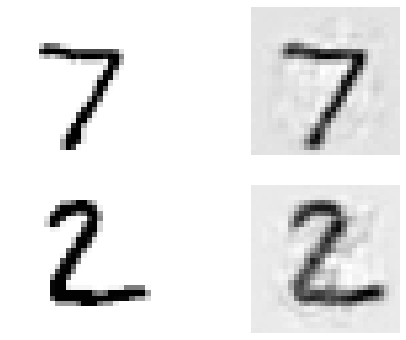

In [34]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
#         X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [36]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
init = tf.global_variables_initializer()

n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", reconstruction_loss_val, "\t희소 손실:", sparsity_loss_val, "\t전체 손실:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 훈련 MSE: 0.7047666 	희소 손실: 0.12352318 	전체 손실: 0.09142406
1 훈련 MSE: 0.704796 	희소 손실: 0.019605529 	전체 손실: 0.05858742
2 훈련 MSE: 0.7048345 	희소 손실: 0.028799854 	전체 손실: 0.054506186
3 훈련 MSE: 0.70477927 	희소 손실: 0.008937162 	전체 손실: 0.045784224
4 훈련 MSE: 0.70475614 	희소 손실: 0.07770297 	전체 손실: 0.05621028
5 훈련 MSE: 0.7046035 	희소 손실: 0.014777578 	전체 손실: 0.037430603
6 훈련 MSE: 0.7048179 	희소 손실: 0.010760792 	전체 손실: 0.032250192
7 훈련 MSE: 0.70467716 	희소 손실: 0.006685371 	전체 손실: 0.028559342
8 훈련 MSE: 0.70488346 	희소 손실: 0.014640239 	전체 손실: 0.027989157
9 훈련 MSE: 0.7049954 	희소 손실: 0.010540727 	전체 손실: 0.025672361
10 훈련 MSE: 0.70476043 	희소 손실: 0.017074438 	전체 손실: 0.025290703
11 훈련 MSE: 0.7047554 	희소 손실: 0.03934033 	전체 손실: 0.029316306
12 훈련 MSE: 0.70469606 	희소 손실: 0.019014362 	전체 손실: 0.024640704
13 훈련 MSE: 0.70488685 	희소 손실: 0.030627202 	전체 손실: 0.025302013
14 훈련 MSE: 0.70481926 	희소 손실: 0.014720345 	전체 손실: 0.020566199
15 훈련 MSE: 0.7045547 	희소 손실: 0.03210661 	전체 손실: 0.023378175
16 훈련 MSE: 0.7047551 	희소 손실: 0.016